In [17]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import random
import transformers
import torchvision.models as models
import torchvision.transforms.functional as vison_functions
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

In [18]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)
max_token_length = 100
vocab_size = 30522
batch_size = 50
epochs = 1
learning_rate = 0.001

In [20]:
data_dir = 'data/Flickr8k'
image_dir = f'{data_dir}/images'
csv_file = f'{data_dir}/captions.txt'

df = pd.read_csv(csv_file)
df['image'] = image_dir+'/'+df['image']
df.head(5)

,image,caption
0,data/Flickr8k/images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,data/Flickr8k/images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,data/Flickr8k/images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,data/Flickr8k/images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,data/Flickr8k/images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [21]:
## Obtain Train Test Split 
train, test = train_test_split(df, test_size=0.988, random_state=1234) #make the split .2 later

## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Obtain Validation and Test Split 
val, test = train_test_split(test, test_size=0.988, random_state=1234) #make the split .5 later

## Reset Indexes 
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

## Let's see how many entries we have
print(train.shape)
print(val.shape)
print(test.shape)

(485, 2)
(479, 2)
(39491, 2)


In [22]:
class ImgSquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return vison_functions.pad(image, padding, 0, 'constant')
    
class AIDataset(Dataset):
    
    def __init__(self, df, train):
        self.df = df
        self.captions = self.df['caption']
        self.images = self.df['image']
        if train:
            self.transforms = transforms.Compose([
                ImgSquarePad(),
                transforms.Resize(300),                          # smaller edge of image resized to 256
                transforms.CenterCrop(300),                      # get 224x224 crop from random location
                transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))])
        else:
            self.transforms = transforms.Compose([
                ImgSquarePad(),
                transforms.Resize(300),                          # smaller edge of image resized to 325
                transforms.CenterCrop(300),                      # get 224x224 crop from random location
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        label = self.captions[index]
        image_name = self.images[index]
        image = Image.open(image_name).convert("RGB")
        
        if (self.transforms):
            image = self.transforms(image)
    
        encoded_labels = tokenizer(label, 
                              return_token_type_ids = False, 
                              return_attention_mask = False, 
                              max_length = max_token_length, 
                              padding = "max_length",
                              return_tensors = "pt")
        # print(encoded_labels)
        # print(encoded_labels["input_ids"].flatten())
        return image.to(device),  encoded_labels["input_ids"].flatten().to(device)
        # return image.to(device),  encoded_labels.to(device)

In [23]:
train_dataset = AIDataset(train, True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = AIDataset(val, False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,drop_last=True)

test_dataset = AIDataset(test, False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


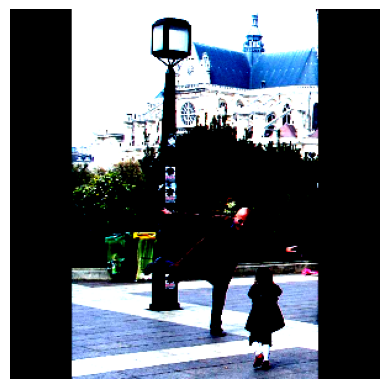

[CLS] a man poses for a little girl, his arms outstretched, with a large church in the background. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [24]:
# get an image from training data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show image and cpation
imshow(torchvision.utils.make_grid(images[19]))
original_tokens = tokenizer.decode(labels[19])
print(original_tokens)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


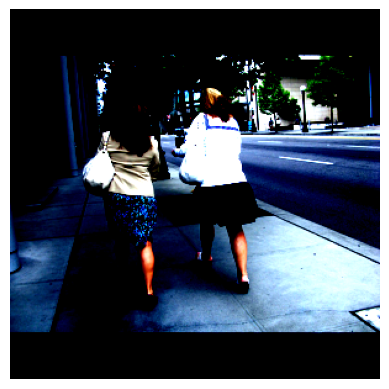

[CLS] two women walking on the sidewalk. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [25]:
# get an image from test data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# show image and cpation
imshow(torchvision.utils.make_grid(images[3]))
original_tokens = tokenizer.decode(labels[3])
print(original_tokens)

In [26]:
class CNN(nn.Module):
    
    def __init__(self, embed_size):
        super().__init__()
        model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad_(False)
        
        modules = list(model.children())[:-1]
        self.model = nn.Sequential(*modules)
        self.dropout = nn.Dropout(0.3)
        self.embed = nn.Linear(model.classifier[1].in_features, embed_size)
        
    def forward(self, image):
        features = self.model(image)
        features = features.view(features.size(0), -1)
        features = self.dropout(features)
        features = self.embed(features)
        return features

In [27]:
class RNN(nn.Module):
    
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, labels):
        h0 = features.unsqueeze(0).to(device)
        c0 = features.unsqueeze(0).to(device)
        embed = self.embedding(labels) 
        
        lstm_out, _ = self.lstm(embed, (h0,c0))
        outputs = self.fc(lstm_out)
        outputs = outputs.view(-1, self.vocab_size)
        return outputs

In [28]:
encoder = CNN(embed_size=512).to(device)
decoder = RNN(embed_size=512, hidden_size=512, vocab_size=vocab_size).to(device)

params = list(decoder.parameters()) + list(encoder.embed.parameters())

In [29]:
def train_loop(dataloader, encoder, decoder, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    size = len(dataloader.dataset)
    for batch, (images, labels) in enumerate(dataloader):
        # zero the parameter gradients
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Forward
        features = encoder(images)
        pred = decoder(features, labels)
        loss = loss_fn(pred, labels.view(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print Progress
        if (batch+1) % 1 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"Progress:[{current:>5d}/{size:>5d}] loss:{loss:>7f}")


def test_loop(dataloader, encoder, decoder, loss_fn, dataloader_type):
    encoder.eval()
    decoder.eval()
    # Initilialize vairables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            # Send data to same device as model
            features = encoder(images)
            pred = decoder(features, labels)

            # Accumalate accuracy and loss
            test_loss += loss_fn(pred, labels.view(-1)).item()
            correct += (pred.argmax(1) == labels.view(-1)).type(torch.float).sum().item()

    # Normalize accuracy and loss
    test_loss /= num_batches
    correct /= size * max_token_length

    # Print test accuracy and averge loss
    print(f"{dataloader_type} Error: Accuracy:{(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

In [30]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params, lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, encoder, decoder, loss_fn, optimizer)
    # test_loop(val_dataloader, encoder, decoder, loss_fn, "Val")
# test_loop(test_dataloader, encoder, decoder, loss_fn, "Test")
print("Done!")

Epoch 1
-------------------------------
Progress:[   50/  485] loss:10.326355
Progress:[  100/  485] loss:7.612280
Progress:[  150/  485] loss:5.864571
Progress:[  200/  485] loss:4.454659
Progress:[  250/  485] loss:3.119509
Progress:[  300/  485] loss:2.202221
Progress:[  350/  485] loss:1.607100
Progress:[  400/  485] loss:1.521881
Progress:[  450/  485] loss:1.401428
Val Error: Accuracy:82.1%, Avg loss:1.297630 

Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


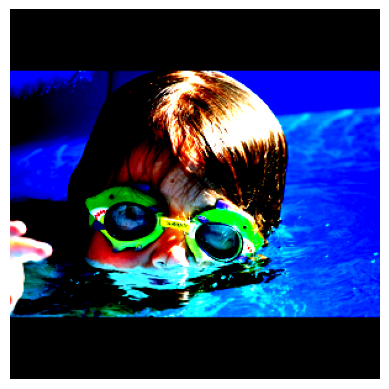

Prediction:
 [CLS] a a [PAD] [PAD] [PAD] [PAD] [PAD] in a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Actual:
 [CLS] a child in colorful goggles plays in a pool. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [65]:
# get a batch from test data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
# specify the sample we want
test_index = 38

# put models in eval mode
encoder.eval()
decoder.eval()
with torch.no_grad():
    # calculate prediction for sample
    features = encoder(images[test_index].unsqueeze(0))
    pred = decoder(features, labels[test_index].unsqueeze(0))
    pred_tokens = tokenizer.decode(pred.argmax(1))
    
    # show results
    imshow(torchvision.utils.make_grid(images[test_index]))
    print(f"Prediction:\n {pred_tokens}")
    print(f"Actual:\n {tokenizer.decode(labels[test_index])}")